In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_16 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/7. Временные ряды/files/16_17.csv', sep=';')
df_18 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/7. Временные ряды/files/18_19.csv', sep=';')
df_18.head(5)

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
# Выбираем данные без временных колонок
df_16_1 = df_16.iloc[:, 2:]
df_18_1 = df_18.iloc[:, 2:]

print(df_16_1.shape, df_18_1.shape)

# Объединяем базы
data_source = pd.concat([df_16_1, df_18_1])
data_source = np.array(data_source)

print(data_source.shape)

(263925, 5) (217947, 5)
(481872, 5)


## Отрисовка графика

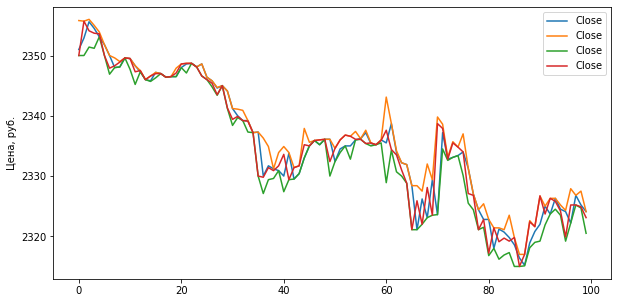

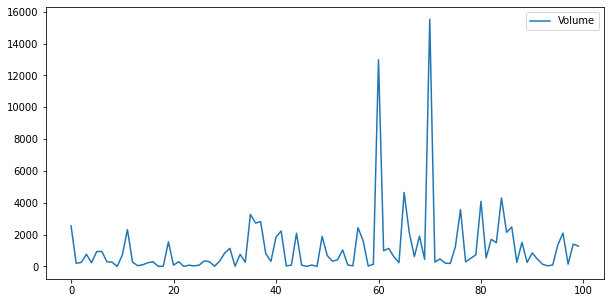

In [ ]:
start = 0   # Начальная точка
win_len = 100 # Длина окна

plt.figure(figsize=(10, 5))
plt.plot(data_source[start:win_len, 0], label="Close")
plt.plot(data_source[start:win_len, 1], label="Close")
plt.plot(data_source[start:win_len, 2], label="Close")
plt.plot(data_source[start:win_len, 3], label="Close")
plt.ylabel('Цена, руб.')
plt.legend()
plt.show()

# volume
plt.figure(figsize=(10, 5))
plt.plot(data_source[start:win_len, 4], label="Volume")
plt.legend()
plt.show()

## Создаём датасет

In [ ]:
data_list = []
i = 0
for row in data_source:
  row_list = [] 
  row_list.append(row[0])  # Close
  row_list.append(abs(row[0] - row[3]))  # Разность "Open" - "Close"
  row_list.append(row[1] - row[0])  # Разность "Max" - "Min"
  row_list.append(row[0] * row[3])  # Произведение "Open" * "Close"
  row_list.append(row[1] * row[0])  # Произведение "Max" * "Min"
  row_list.append(1/(row[0] + 1e-3))  # Oбратное значение "Open" x_new = 1/(x + 1e-3)
  row_list.append(1/(row[1] + 1e-3))  # Oбратное значение "Max"
  row_list.append(1/(row[2] + 1e-3))  # Oбратное значение "Min"
  row_list.append(1/(row[3] + 1e-3))  # Oбратное значение "Close"

  if i > 0:
    row_list.append(row[0] - data_source[i-1][0]) # Первая производная канала "Open" (x[n] - x[n-1])
    row_list.append(row[1] - data_source[i-1][1]) # Первая производная канала "Max"
    row_list.append(row[2] - data_source[i-1][3]) # Первая производная канала "Min"
    row_list.append(row[3] - data_source[i-1][3]) # Первая производная канала "Close"
    if i > 1:
      row_list.append(row[0] - 2*data_source[i-1][0] + data_source[i-2][0])  # Вторая производная канала "Open" (x[n] - 2*x[n-1] + x[n-2])
      row_list.append(row[1] - 2*data_source[i-1][1] + data_source[i-2][1])  # Вторая производная канала "Max"
      row_list.append(row[2] - 2*data_source[i-1][2] + data_source[i-2][2])  # Вторая производная канала "Min"
      row_list.append(row[3] - 2*data_source[i-1][3] + data_source[i-2][3])  # Вторая производная канала "Close"
    else:
      row_list.append(0)
      row_list.append(0)
      row_list.append(0)
      row_list.append(0)                                                 
  else:
    row_list.append(0)
    row_list.append(0)
    row_list.append(0)
    row_list.append(0)
    row_list.append(0)
    row_list.append(0)
    row_list.append(0)
    row_list.append(0)

  data_list.append(row_list)
  i += 1

data = np.array(data_list)

print(data.shape)


(481872, 17)


## На 1 - 10 шагов

In [ ]:
# --- НА 10 ШАГОВ ВПЕРЁД ---
win_len = 50  # Длина окна
test_len = 30000  # Длина валидационной выборки
train_len = data.shape[0] - test_len  # Длина обучающей выборки
steps_forward = 10

# Делим данные на тренировочную и тестовую выборки 
x_train_10 = data[:train_len-steps_forward]
x_test_10 = data[train_len+win_len+2:-steps_forward+1]

# Масштабируем данные
x_scaler_10 = StandardScaler()
x_scaler_10.fit(x_train_10)
x_train_10_s = x_scaler_10.transform(x_train_10)
x_test_10_s = x_scaler_10.transform(x_test_10)

# y_train на 10 шагов вперед (берём первые 10 значений из каждого окна, в генераторе они будут результатом)
y_train_10 = np.array([data[:train_len, 0][i:i+steps_forward] for i in range(train_len-steps_forward)])
y_test_10 = np.array([data[train_len+win_len+2:, 0][i:i+steps_forward] for i in range(test_len-win_len-steps_forward-1)])

y_scaler_10 = StandardScaler()
y_scaler_10.fit(y_train_10)
y_train_10_s = y_scaler_10.transform(y_train_10)
y_test_10_s = y_scaler_10.transform(y_test_10)

print(f'Прогнозирование на 10 шагов, x_train_10_s.shape {x_train_10_s.shape}, y_train_10_s.shape {y_train_10_s.shape}')
print(f'Прогнозирование на 10 шагов, x_test_10_s.shape {x_test_10_s.shape}, y_test_10_s.shape {y_test_10_s.shape}')

Прогнозирование на 10 шагов, x_train_10_s.shape (451862, 17), y_train_10_s.shape (451862, 10)
Прогнозирование на 10 шагов, x_test_10_s.shape (29939, 17), y_test_10_s.shape (29939, 10)


## Создаём генератор
Служебный класс для генерации батчей временных данных.
keras.preprocessing.sequence.TimeseriesGenerator(
*   data,  # x_train - Numpy 2D, а ось 0 должна быть измерением времени
*   targets,  # y_train, той же длинны что и x_train 
*   length,  # Длина выходных последовательностей (длина окна).
*   sampling_rate=1,  # Частота выборки значений из окна 
*   stride=1,  # Шаг смещения
*   start_index=0,  # Точки данных предшествующие start_index, не будут использоваться в выходных последовательностя 
*   end_index=None, 
*   shuffle=False,  # Перемешать 
*   reverse=False,  # Реверс последовательности
*   batch_size=128
)

**Возвращает экземпляр последовательности Sequence**

In [ ]:
# 10 Шагов вперёд
train_gen_10 = TimeseriesGenerator(
    x_train_10_s,  # Numpy 2D, а ось 0 должна быть измерением времени
    y_train_10_s,  # Той же длинны что и x_train      
    length=win_len,  # Длина выходных последовательностей (длина окна).
    batch_size=20
)

# Генератор для тестовой выборки
test_gen_10 = TimeseriesGenerator(
    x_test_10_s,
    y_test_10_s,
    length=win_len, 
    batch_size=20
)

print(train_gen_10[10][0].shape, train_gen_10[10][1].shape)

(20, 50, 17) (20, 10)


## Conv1D

Epoch 1/20
22591/22591 [==============================] - 63s 3ms/step - loss: 0.0517 - mape: 61.5246 - val_loss: 0.0015 - val_mape: 1.7716
Epoch 2/20
22591/22591 [==============================] - 57s 3ms/step - loss: 0.0014 - mape: 11.7746 - val_loss: 5.4056e-04 - val_mape: 1.0222
Epoch 3/20
22591/22591 [==============================] - 56s 2ms/step - loss: 7.8997e-04 - mape: 13.4484 - val_loss: 9.2603e-04 - val_mape: 1.7143
Epoch 4/20
22591/22591 [==============================] - 57s 3ms/step - loss: 6.0227e-04 - mape: 9.2932 - val_loss: 2.6864e-04 - val_mape: 0.7697
Epoch 5/20
22591/22591 [==============================] - 56s 2ms/step - loss: 4.7138e-04 - mape: 8.5786 - val_loss: 3.0823e-04 - val_mape: 0.8225
Epoch 6/20
22591/22591 [==============================] - 56s 2ms/step - loss: 3.6261e-04 - mape: 5.4997 - val_loss: 0.0023 - val_mape: 2.1734
Epoch 7/20
22591/22591 [==============================] - 57s 3ms/step - loss: 3.4428e-04 - mape: 5.2139 - val_loss: 3.4447e-04 - v

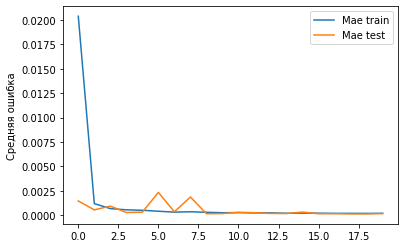

In [ ]:
mode_c1d = Sequential()
mode_c1d.add(Conv1D(128, 20, input_shape=(win_len, 17), activation='linear'))
mode_c1d.add(GlobalMaxPooling1D())
mode_c1d.add(Dense(128, activation='linear'))
mode_c1d.add(Dense(10, activation='linear'))
mode_c1d.compile(loss='mse', optimizer=Adam(lr=1e-4), metrics=['mape'])

history = mode_c1d.fit(
    train_gen_10,
    epochs=20, 
    verbose=1,
    validation_data=test_gen_10
)

plt.plot(history.history['loss'], label='Mae train')
plt.plot(history.history['val_loss'], label='Mae test')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()


## Функции визуализации

In [ ]:
# Функция рассчитывает результаты прогнозирования сети
# В аргументы принимает сеть (current_model) и проверочную выборку
# Возвращает результаты предсказания в исходной размерности
def predict_value(current_model, x, y, y_scaler):
  y_predict_s = current_model.predict(x)
  y_predict = y_scaler.inverse_transform(y_predict_s)
  y_real = y_scaler.inverse_transform(y)
  return y_predict, y_real

# Функция визуализации правельных и предсказанных значенмй
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
def show_result(start, step, y_predict, y, steps_forward):
  plt.figure(figsize=(20, 3))
  plt.plot(y_predict[:, steps_forward][start:start+step], label=f'Прогноз, кличество шагов {steps_forward}')
  plt.plot(y[:, 0][start:start+step], label='Реальные значения')
  plt.xlabel('Выборки по времени')
  plt.ylabel('Значения')
  plt.legend()
  plt.show()

## Выводим результаты

(1, 29889, 50, 17) (1, 29889, 10)
(29889, 50, 17) (29889, 10)


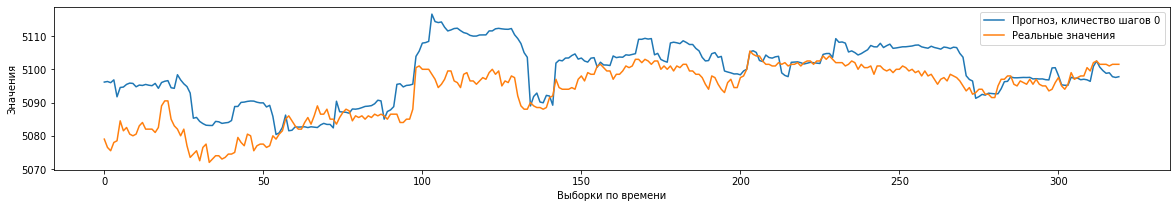

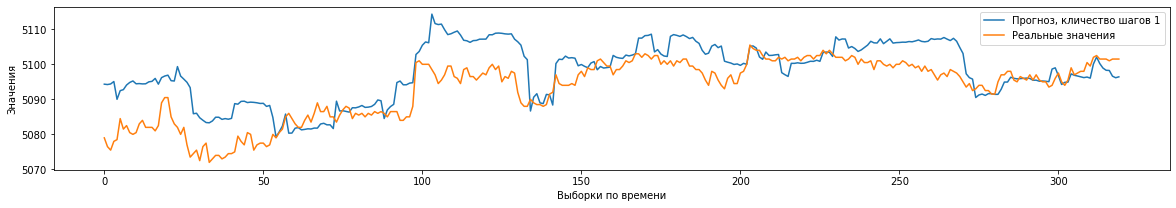

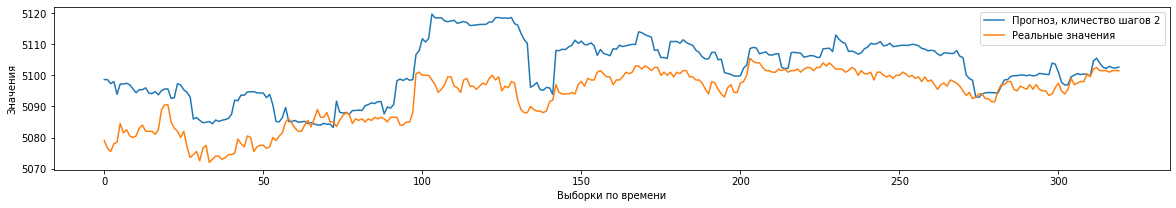

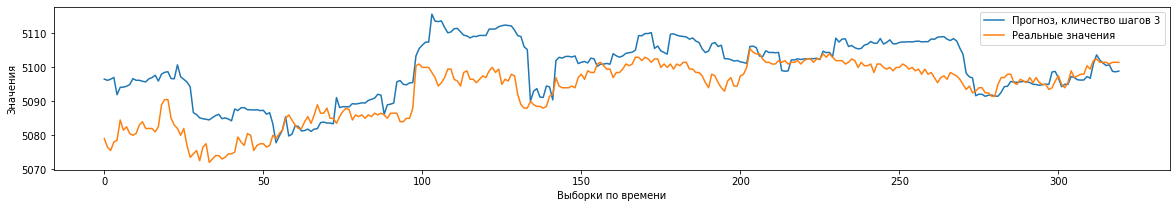

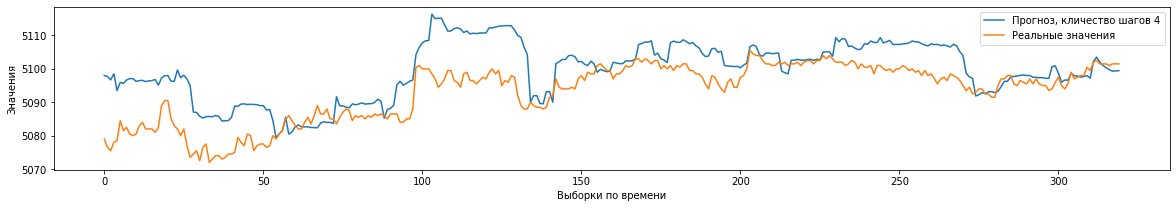

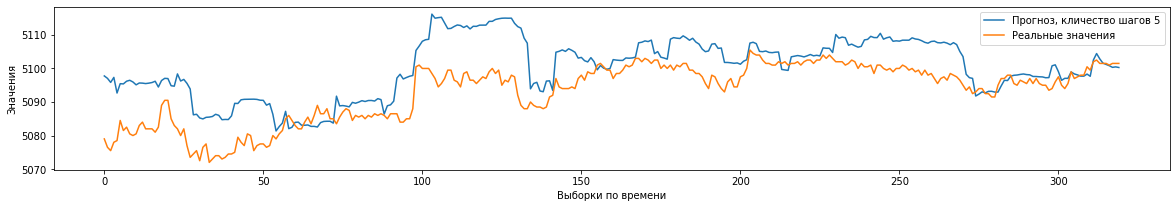

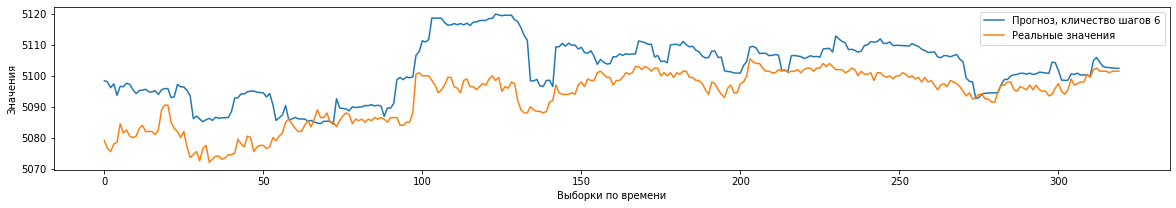

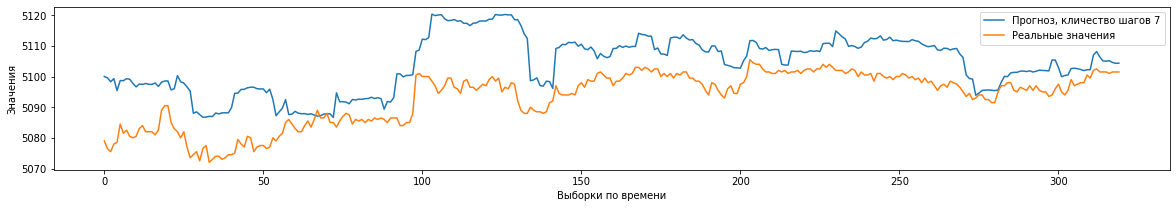

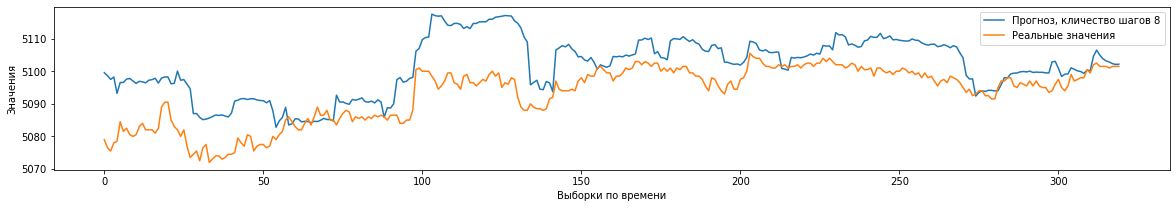

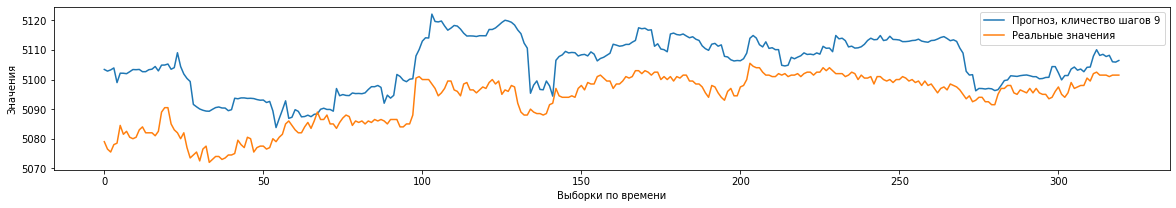

In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим x_val, y_val для проверки
val_gen = TimeseriesGenerator(
    x_test_10_s, 
    y_test_10_s,
    length=win_len,
    batch_size=len(x_test_10_s)  # Размер batch будет равен длине нашей выборки
) 

x_val_list = []
y_val_list = []
for i in val_gen:
  x_val_list.append(i[0])
  y_val_list.append(i[1])

x_val = np.array(x_val_list)
y_val = np.array(y_val_list)

print(x_val.shape, y_val.shape)
print(x_val[0].shape, y_val[0].shape)

y_predict, y_real = predict_value(mode_c1d, x_val[0], y_val[0], y_scaler_10) # Прогнозируем данные

# Отображаем графики
show_result(20000, 320, y_predict, y_real, 0)
show_result(20000, 320, y_predict, y_real, 1)
show_result(20000, 320, y_predict, y_real, 2)
show_result(20000, 320, y_predict, y_real, 3)
show_result(20000, 320, y_predict, y_real, 4)
show_result(20000, 320, y_predict, y_real, 5)
show_result(20000, 320, y_predict, y_real, 6)
show_result(20000, 320, y_predict, y_real, 7)
show_result(20000, 320, y_predict, y_real, 8)
show_result(20000, 320, y_predict, y_real, 9)

# Выводы
Результат немного лучше, но всё же увеличение числа параметров не дало необходимого увеличения точности предсказания на несколько шагов вперёд. Предсказание иногда опаздывает относительно реальных событий. Всё дело в том, что нейронная сеть ищет закономерности, а график акций больше похож на белый шум. Таким образом идёт практически апроксимация по предыдущим значениям. Как вариант дальнейшего развития направления - можно сделать анализ с привязкой строго к дням недели. В пятницу вечером народ привык закрывать сомнительные позиции, а понедельник часто открывается гепом. Эти и подобные закономерности сеть может поймать. 

Кроме того, биржевая торговля - это во многом ожидание продавцов и покупателей. Из их ожиданий и складывается цена. Можно пропарсить форумы и сделать анализ текста, опять таки, выборка от одного дня до недели, максимум 21 день. В таком случае мнение людей будет аналогом метода "случайных деревьев".

Можно попробовать связать динамику биржевых индексов и др. Т.е. делать анализ не только курса конкретной акции, но и учитывать другие факторы, например новостной фон.
